In [72]:
%run init_notebookspace.py
from settings import DATA_DIR, MODEL_DIR

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\memoire1\data


<Figure size 1440x432 with 0 Axes>

In [73]:
from config import mod7_params, fred_dict, recession_dict

In [74]:
%matplotlib inline

from gEconpy.classes.model import gEconModel
from gEconpy.classes.transformers import IntervalTransformer
from gEconpy import compile_to_statsmodels
from gEconpy.plotting import plotting as gp


import matplotlib.pyplot as plt
import seaborn as sns
from src.plotting import plot_dfs
from src.gp_plotting import plot_sm_results
from src.process_data import load_data

import numpy as np
import xarray as xr
import pandas as pd

import os

from config import plt_config
plt.rcParams.update(plt_config)

load data

In [75]:
from config import fred_dict

df = load_data('prepro_data.csv', DATA_DIR, fred_dict)
df = df.rename(columns={'pi_s': 'pi_obj'}).drop(['pi_c', 'Ix', 'Zx'], axis=1)
train = df[df['is_test'] == False].drop('is_test', axis=1).copy()
test = df[df['is_test'] == True].drop('is_test', axis=1).copy()

Error occured 'is_test', file_dict may be incomplete


load & solve model

In [76]:
mod = gEconModel(os.path.join(MODEL_DIR, 'gEconpy_mod7_nk.gcn'), verbose=True)

Model Building Complete.
Found:
	25 equations
	25 variables
	The following "variables" were defined as constants and have been substituted away:
		B_t
	5 stochastic shocks
		 0 / 5 has a defined prior. 
	18 parameters
		 0 / 18 has a defined prior. 
	2 calibrating equations
	2 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [77]:
# assign parameters
mod.free_param_dict.update(mod7_params)

In [78]:
mod.steady_state()
mod.solve_model()
mod.check_bk_condition();

Steady state found! Sum of squared residuals is 2.3034213894186284e-23
Solution found, sum of squared residuals:  5.233950627320991e-29
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000
Model solution has 14 eigenvalues greater than one in modulus and 11 forward-looking variables.
Blanchard-Kahn condition is satisfied.


#### drawing from priors

In [79]:
from scipy.stats import gamma, norm, beta
import scipy

In [86]:
prior_dict = {
    # 'alpha': beta(1.4, 10),
    # 'beta': beta(.9, 1.5),
    'sigma_C': gamma(a=3.9, loc=0, scale=0.757575757575758),
    # 'sigma_L': gamma(a=3.9, loc=0, scale=0.757575757575758)
            }

In [87]:
def solve_updated_mod(mod, verbose: bool=True):
    
    # solve for steady state
    mod.steady_state(verbose=verbose)
    is_solved = mod.steady_state_solved
    if not is_solved:
        return False, mod
    
    # solve model, capture np.LinAlgEr
    try:
        mod.solve_model(verbose=verbose)
    except np.linalg.LinAlgError:
        return False, mod

    # check blanchard kahn
    is_bk = mod.check_bk_condition(return_value='bool', verbose=verbose)
            
    return is_solved & is_bk, mod

In [88]:
from filterpy.kalman import KalmanFilter
def get_kalman_log_likelihood(observed_vars: list, all_vars: list,
                              measurements: np.array, T: np.array,
                              R_diag: list, ret_all: bool = False):
    
    # outputs
    log_likelihood = []
    mu, cov = None, None
    
    if ret_all:
        mu, cov = [], []
    
    observed_ind = [all_vars.index(item) for item in observed_vars]
    
    # sanity
    # add measurement == observed sanity
    for i in observed_vars:
        assert (i in all_vars) == True, f"{i} not in filter_vars"
        
    
    xdim = len(all_vars)
    zdim = len(observed_vars)
        
    # initialising the Kalman Filter
    kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
    kfilter.F = T
    kfilter.R = np.diag(R_diag)
    for i, ind in enumerate(observed_ind):
        kfilter.H[i, ind] = 1
        
    # predict, update, loglike
    for i in measurements:
        kfilter.predict()
        kfilter.update(i)
        
        log_likelihood.append(kfilter.log_likelihood)
        if ret_all:
            mu.append(kfilter.x_post)
            cov.append(kfilter.P_post)
            
    return log_likelihood, mu, cov

In [89]:
test, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                           list(mod.T.columns),
                                           train[["Y", "pi_obj"]].values,
                                           T=mod.T.values,
                                           R_diag=[.01, .01],
                                           ret_all=False)

In [90]:
sample_dict = {}

# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
accepted  = 0.0


# args: mod, base_mod_params, draw_from_priors, 
# get log-likelyhood
for i in range(0, 10):
    
    # reset params
    mod.free_param_dict.update(mod7_params)
    
    # old log_likelihood
    old_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    old_loglike = sum(old_loglike)

    # draw params from prior & update
    prior = {k: v for k, v in zip(prior_dict.keys(), [item.rvs() for item in prior_dict.values()])}
    mod.free_param_dict.update(prior)
    
    # solve model
    is_solved, mod = solve_updated_mod(mod, verbose=False)
    if not is_solved: continue
    
    # new loglikelihood
    new_loglike, _, _ = get_kalman_log_likelihood(["Y", 'pi_obj'], 
                                                   list(mod.T.columns),
                                                   train[["Y", "pi_obj"]].values,
                                                   T=mod.T.values,
                                                   R_diag=[.01, .01],
                                                   ret_all=False)
    new_loglike = sum(new_loglike)
    
    # save output 
    sample_dict[i] = dict(
        zip(['is_solved', 'params', 'T', 'R', 'loglike'], 
        [is_solved, mod.free_param_dict, mod.T, mod.R, new_loglike])
    )
        
    # if (new_loglike > old_loglike):
    #     A.append(new_alpha)
    #     accepted = accepted + 1.0  # monitor acceptance
    # else:
    #     u = random.uniform(0.0,1.0)
    #     if (u < math.exp(new_loglik - old_loglik)):
    #         A.append(new_alpha)
    #         accepted = accepted + 1.0  # monitor acceptance
    #     else:
    #         A.append(old_alpha)

print(f"Acceptance rate = {str(accepted/10000.0)}")
    
    

Acceptance rate = 0.0


In [91]:
sample_dict.keys()

dict_keys([2, 3, 4, 6, 8])

In [92]:
# initial guess for alpha as array.
guess = [3.0]
# Prepare storing MCMC chain as array of arrays.
A = [guess]
# define stepsize of MCMC.
stepsizes = [0.005]  # array of stepsizes
accepted  = 0.0

# Metropolis-Hastings with 10,000 iterations.
for n in range(10000):
    old_alpha  = A[len(A)-1]  # old parameter value as array
        
    old_loglik = evaluateLogLikelihood(old_alpha, D, N, M_min, M_max)
    # old_loglik = stats.multivariate_normal.logpdf(old_alpha, rv.mean(), rv.std()**2)
    
    # Suggest new candidate from Gaussian proposal distribution.
    new_alpha = numpy.zeros([len(old_alpha)])
    for i in range(len(old_alpha)):
        # Use stepsize provided for every dimension.
        # new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
        new_alpha[i] = random.gauss(old_alpha[i], stepsizes[i])
        
    new_loglik = evaluateLogLikelihood(new_alpha, D, N, M_min, M_max)
    # new_loglik = stats.multivariate_normal.logpdf(new_alpha, rv.mean(), rv.std()**2)
    
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A.append(new_alpha)
        accepted = accepted + 1.0  # monitor acceptance
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A.append(new_alpha)
            accepted = accepted + 1.0  # monitor acceptance
        else:
            A.append(old_alpha)

print(f"Acceptance rate = {str(accepted/10000.0)}")

NameError: name 'evaluateLogLikelihood' is not defined

## Estimation

In [99]:
no = 2
sample = sample_dict[no].copy()

In [100]:
# filter_vars = list(sample['T'].index[len(sample['T']) - (sample['T'] == 0).sum() != 0])
filter_vars = list(sample['T'].columns)

observed = ["Y", "pi_obj"]
observed_ind = [filter_vars.index(item) for item in observed]

for i in observed:
    assert (i in filter_vars) == True, f"{i} not in filter_vars"
    
xdim = len(filter_vars)
zdim = len(observed)
print(f'xdim: {xdim} \nzdim: {zdim}')

xdim: 25 
zdim: 2


In [101]:
F = sample_dict[no]['T'].loc[filter_vars, filter_vars].values
F.shape

(25, 25)

In [102]:
R = np.eye(zdim) * 0.01
R

array([[0.01, 0.  ],
       [0.  , 0.01]])

In [103]:
kfilter = KalmanFilter(dim_x=xdim, dim_z=zdim)
kfilter.F = F
kfilter.R = R
for i, ind in enumerate(observed_ind):
    kfilter.H[i, ind] = 1
kfilter.H

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [104]:
kfilter.R

array([[0.01, 0.  ],
       [0.  , 0.01]])

In [105]:
mod.R.loc[observed]

,epsilon_R,epsilon_T,epsilon_Y,epsilon_pi,epsilon_preference
Y,-4.252038e+00,-5.809157e-01,5.284028e-01,1.693644,3.108404e-01
pi_obj,-9.811555e-17,-3.005811e-18,2.892069e-17,1.000000,-1.999602e-17


In [106]:
kfilter.Q.shape

(25, 25)

In [107]:
zs = train[observed].values

In [109]:
kfilter.predict()
kfilter.update(zs[0])
kfilter.log_likelihood_of(zs[0])

-3.3787407687578788

In [132]:
mu, cov, _, _ = kfilter.batch_filter(zs)

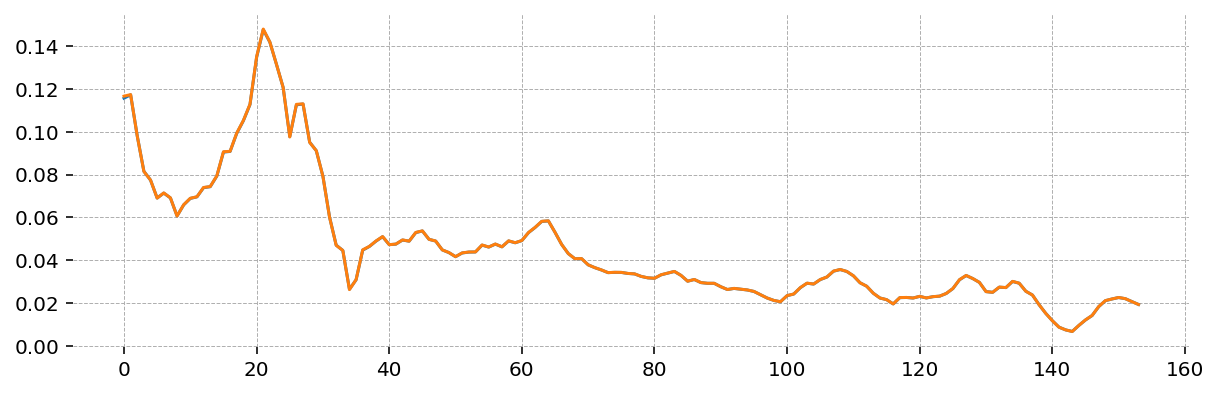

In [133]:
plt.plot(mu.reshape(-1, kfilter.dim_x)[:, 15])
plt.plot(train.pi_obj.values)

In [134]:
mu = pd.DataFrame(mu.reshape(-1,kfilter.dim_x), columns=filter_vars, index=train.index)

In [ ]:
plt.plot(mu.I, label='filter')
plt.plot(train.I, label='data')
plt.legend(['filter', 'data'])